In [1]:
%matplotlib inline
import matplotlib
import numpy as np
from numpy import genfromtxt
from ast import literal_eval
from scipy.misc import *
import matplotlib.pyplot as plt
import sklearn.datasets
import cv2
import theano
import theano.tensor as T
import lasagne

In [56]:
drp = lasagne.layers.DropoutLayer
conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer
fc = lasagne.layers.DenseLayer
CHANNELS_NUM = 1
IMAGE_WIDTH = 224
IMAGE_HIGHT = 148
CLASSES_NUM = 2
EPOCHS_NUM = 500
BATCH_SIZE = 4
LEARNING_RATE = 0.0001
DATASET_FACES_NUM = 450
DATASET_BG_NUM = 900
DATASET_SIZE = DATASET_FACES_NUM + DATASET_BG_NUM

In [9]:
def read_image(i, face=True):
    if face:
        im_name = 'Caltech/PNGImages/faces/image_{:0>4}.png'.format(i+1)
        rgb = imresize(plt.imread(im_name), (IMAGE_HIGHT, IMAGE_WIDTH))
        return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    else:
        im_name = 'Caltech/PNGImages/background/image_{:0>4}.png'.format(i+1)
        return imresize(plt.imread(im_name), (IMAGE_HIGHT, IMAGE_WIDTH))
    
def read_label(i, face=True):
    if face:
        with open("Caltech/Annotations/faces/image_{:0>4}.txt".format(i+1)) as f:
            last = f.readlines()[-1].decode()
            (last.split(':')[-1]).split('-')

def load_data():

    X_data = np.zeros((DATASET_SIZE, CHANNELS_NUM, IMAGE_HIGHT, IMAGE_WIDTH))
    y_data = np.zeros(DATASET_SIZE)
    
    for i in range(DATASET_FACES_NUM):
        X_data[i,:,:,:] = read_image(i, face=True)
        y_data[i] = 0
    for i in range(DATASET_BG_NUM):
        X_data[DATASET_FACES_NUM+i,:,:,:] = read_image(i, face=False)
        y_data[i] = 1
        
    mask = np.random.choice(DATASET_SIZE, int((4.0/5)*DATASET_SIZE))
    X_train = X_data[mask, :, :, :]
    y_train = y_data[mask]
    X_val_tst = X_data[~mask, :, :, :]
    y_val_tst = y_data[~mask]
    val_mask = np.random.choice(X_val_tst.shape[0], int((1.0/10)*DATASET_SIZE))
    X_valid = X_val_tst[val_mask, :, :, :]
    y_valid = y_val_tst[val_mask]
    X_test = X_val_tst[~val_mask, :, :, :]
    y_test = y_val_tst[val_mask]
    
    print X_train.shape, X_valid.shape, X_test.shape

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        y_train=y_train.astype('int32'),
        X_valid=lasagne.utils.floatX(X_valid),
        y_valid=y_valid.astype('int32'),
        X_test=lasagne.utils.floatX(X_test),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=CLASSES_NUM,)

(1080, 1, 148, 224) (135, 1, 148, 224) (135, 1, 148, 224)


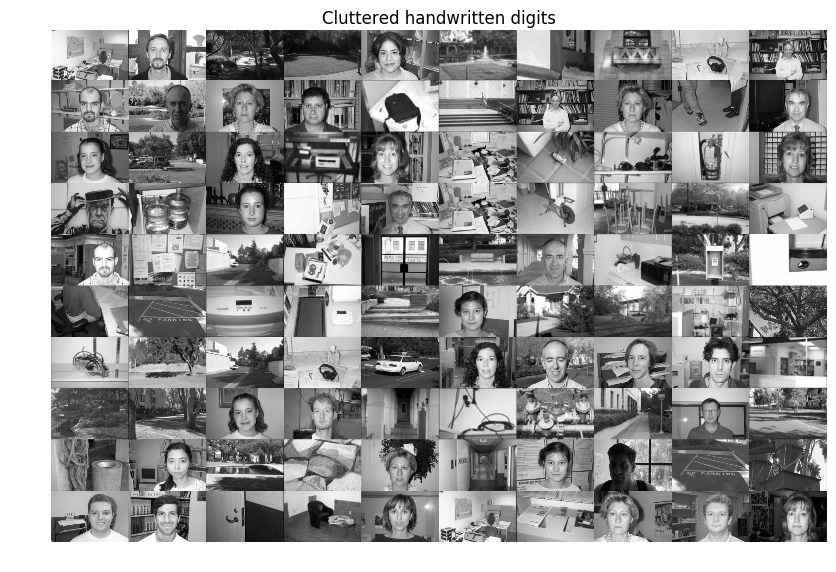

In [10]:
data = load_data()

idx = 0
canvas = np.zeros((IMAGE_HIGHT*10, 10*IMAGE_WIDTH))
for i in range(10):
    for j in range(10):
        canvas[i*IMAGE_HIGHT:(i+1)*IMAGE_HIGHT, j*IMAGE_WIDTH:(j+1)*IMAGE_WIDTH] = data['X_train'][idx].reshape((IMAGE_HIGHT, IMAGE_WIDTH))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.axis('off')

plt.show()

In [50]:
def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)

    # Localization network
    b = np.zeros((2, 3), dtype=theano.config.floatX)
    b[0, 0] = 1
    b[1, 1] = 1
    b = b.flatten()
    loc_l1 = pool(l_in, pool_size=(2, 2))
    loc_l2 = conv(
        loc_l1, num_filters=8, filter_size=(5, 5), W=ini)
    loc_l3 = pool(loc_l2, pool_size=(2, 2))
    loc_l4 = conv(loc_l3, num_filters=8, filter_size=(5, 5), W=ini)
    loc_l5 = lasagne.layers.DenseLayer(
        loc_l4, num_units=50, W=lasagne.init.HeUniform('relu'))
    loc_out = lasagne.layers.DenseLayer(
        loc_l5, num_units=6, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity)
    
    # Transformer network
    l_trans1 = lasagne.layers.TransformerLayer(l_in, loc_out, downsample_factor=2.0)
    print "Transformer network output shape: ", l_trans1.output_shape
    
    # Classification network
    class_l1 = conv(
        l_trans1,
        num_filters=16,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    l_drp1 = drp(class_l1, p=0.3)
    class_l2 = pool(l_drp1, pool_size=(2, 2))
    class_l3 = conv(
        class_l2,
        num_filters=16,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    l_drp2 = drp(class_l3, p=0.3)
    class_l4 = pool(l_drp2, pool_size=(2, 2))
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=64,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    l_drp3 = drp(class_l5, p=0.3)
    l_out = lasagne.layers.DenseLayer(
        l_drp3,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    )

    return l_out, l_trans1

In [57]:
X = T.tensor4()
y = T.ivector()

model, l_transform = build_model(IMAGE_HIGHT, IMAGE_WIDTH, CLASSES_NUM)
model_params = lasagne.layers.get_all_params(model, trainable=True)

# training output
output_train = lasagne.layers.get_output(model, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval, transform_eval = lasagne.layers.get_output([model, l_transform], X, deterministic=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

train = theano.function([X, y], [cost, output_train], updates=updates)
eval = theano.function([X], [output_eval, transform_eval])

Transformer network output shape:  (None, 1, 74, 112)


In [58]:
def train_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        if i % 10 == 0:
            print i,
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train = train(X_batch, y_batch)
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
    print ""
    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    output_eval, transform_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc, transform_eval

In [62]:
valid_accs, train_accs, test_accs = [], [], []
try:
    for n in range(EPOCHS_NUM):
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'])
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
            #store
            all_params = lasagne.layers.get_all_params(model)
            all_param_values = [p.get_value() for p in all_params]

            output = open('params.oo', 'wb')
            pickle.dump(all_param_values, output)
            output.close()
            
            
        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}".format(
                n, train_cost, train_acc, valid_acc, test_acc)
except KeyboardInterrupt:
    pass

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 
Epoch 0: Train cost 0.687461508126, Train acc 0.653703703704, val acc 0.674074074074, test acc 0.674074074074
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 
Epoch 1: Train cost 0.684490954732, Train acc 0.653703703704, val acc 0.674074074074, test acc 0.674074074074
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 
Epoch 2: Train cost 0.687392140696, Train acc 0.653703703704, val acc 0.674074074074, test acc 0.674074074074
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 
Epoch 3: Train cost 0.677289167535, Train acc 0.653703703704, val acc 0.674074074074, test acc 0.674074074074
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 
Epoch 4: Train cost 0.674327923765, Train acc 0.653703703704, val acc 

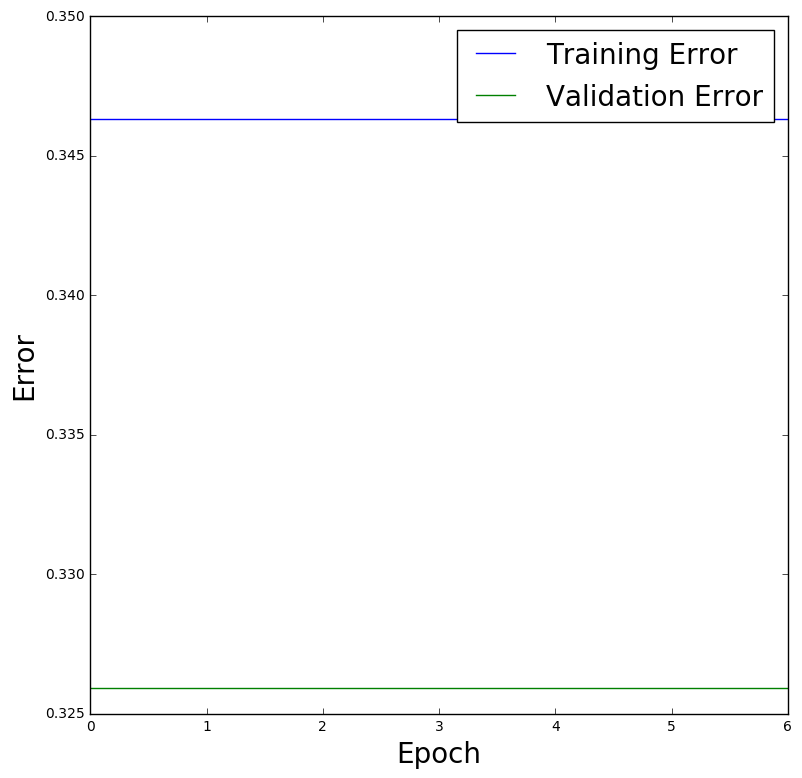

In [63]:
plt.figure(figsize=(9,9))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

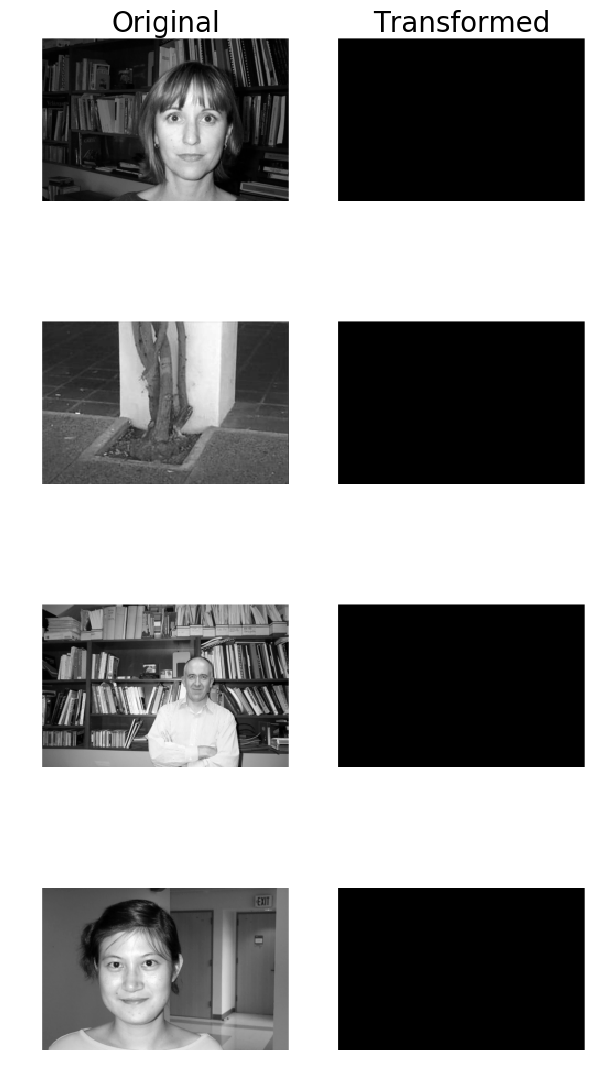

In [64]:
plt.figure(figsize=(7,14))
for i in range(4):
    plt.subplot(421+i*2)
    plt.imshow(data['X_test'][i].reshape(IMAGE_HIGHT, IMAGE_WIDTH), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original', fontsize=20)
    plt.axis('off')
    plt.subplot(422+i*2)
    plt.imshow(test_transform[i].reshape(IMAGE_HIGHT//2, IMAGE_WIDTH//2), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed', fontsize=20)
    plt.axis('off')
    
plt.show()